<a href="https://colab.research.google.com/github/moki2744/Section_Project/blob/main/Section2_project_%EA%B9%80%EC%A2%85%EB%AA%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature 정보
Auction_key : 경매 아파트 고유 키값  
Auction_miscarriage_count : 총유찰횟수  
Total_land_auction_area : 총토지경매면적(㎡)  
Total_building_auction_area : 총건물경매면적(㎡)  
Total_appraisal_price : 총감정가  
Final_auction_date : 마지막 경매 날짜(낙찰)   
addr_do : 주소_시도  
addr_si : 주소_시군구  
addr_dong : 주소_읍면동   
Apartment_usage : 건물(토지)의 대표 용도  
Preserve_regist_date : 보존등기일, 건물을 신축하고 처음으로 등기  
Total_floor : 총층수  
Current_floor : 현재층수  
Share_auction_YorN : 지분경매 여부(Y/N), 하나의 부동산이 전체가 아닌 일부만 경매가 진행 (하나의 부동산의 공유자가 지분으로 소유권을 가지고 있을 때 그중 일부 지분만 경매가 진행)  
Hammer_price : 낙찰가

## 데이터 불러오기 및 EDA 진행
1. 내가 원하는 Feature만 불러온다.
2. data engineering 실시한다.
 - 아파트 층수에 대한 등급 부여
 - 건물이 만들어진 시기 ~ 경매가 완료된 시기 까지의 기간
 - 경매가 완료된 시점->날짜 정보로 변환
 - 카테고리컬 데이터 변환 실시
 


In [56]:
# 데이터셋 불러오기
# https://dacon.io/competitions/official/17801/overview/description
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install category_encoders
# ! pip install pdpbox
# ! pip install shap
# !pip install eli5

# 서울/부산 지역의 낙찰가를 포함하여 경매 물건 아파트의 위치, 감정가, 경매 개시/종결일 등의 기본 정보(*최근2년)
df=pd.read_csv("New_Auction_master_train.csv") 

In [57]:
df_select = df[['Auction_miscarriage_count', 'Total_land_auction_area', 'Total_building_auction_area', 'Total_appraisal_price', 'Final_auction_date', 'addr_do', 'addr_si', 'addr_dong', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor', 'Current_floor', 'Share_auction_YorN', 'Hammer_price']]

In [58]:
df_select.rename(columns = {'Auction_miscarriage_count':'유찰횟수',
                            'Total_land_auction_area':'총_토지경매면적',
                            'Total_building_auction_area':'총_건물경매면적',
                            'Total_appraisal_price':'총_감정가',
                            'Final_auction_date':'낙찰날짜',
                            'addr_do':'주소_도',
                            'addr_si':'주소_시',
                            'addr_dong':'주소_동',
                            'Apartment_usage':'건물용도',
                            'Preserve_regist_date':'최초등기일',
                            'Total_floor':'총층수',
                            'Current_floor':'현재층수',
                            'Share_auction_YorN':'지분경매여부',
                            'Hammer_price':'낙찰가'},inplace=True)

In [59]:
# outlier 제거

df_select=df_select.drop(df_select[df_select['낙찰가'] > np.percentile(df_select['낙찰가'], 99.99)].index)

In [67]:
# 기준모델 생성 - 총_감정가
y_pred = df_select['총_감정가']

print('RMSE 값:', mean_squared_error(df_select['낙찰가'], df_select['총_감정가'])**0.5)

RMSE 값: 110374417.20978819


In [70]:
# 데이터 Split

target = '낙찰가'
features = df_select.columns.drop(target)

X_train, X_test, y_train, y_test = train_test_split(df_select[features], df_select[target], test_size=0.2, random_state=42)

In [92]:
def EDA(df):
  df_copy = df.copy()
# 최초 등기일 ~ 경매가 완료된 시기 까지의 기간 (건물 나이)
  df_copy['최초등기일'] = pd.to_datetime(df_copy['최초등기일'], errors = 'coerce')
  df_copy['낙찰날짜'] = pd.to_datetime(df_copy['낙찰날짜'], errors = 'coerce')
  df_copy['낙찰시_건물나이'] = (df_copy['낙찰날짜'] - df_copy['최초등기일']).dt.days
  df_copy.drop(columns='최초등기일', inplace=True)
# 경매가 완료된 시점->날짜 정보로 변환 (거래가 발생한 시기별 가격차이가 있는지?)
  cutoff = pd.to_datetime('2016-04-01')
  df_copy['낙찰날짜'] = (df_copy['낙찰날짜'] - cutoff).dt.days
# 아파트 층수에 대한 등급 부여
# 1. 아파트 총 층수가 10층 이하일때 -> 1,2,3층 : 1 / 4,5,6층 : 2 / 7,8,9,10 : 3
# 2. 아파트 총 층수가 10층 초과일때 -> 하위 30% : 1 / 상위40% : 3 / 나머지 : 2
  df_copy["층수등급"] = df_copy.apply(lambda x: 'A' if ((x.총층수 <= 10) & (x.현재층수 >= 7)) or ((x.총층수 > 10) & ((x.현재층수 / x.총층수) >= 0.6))
                                            else 'C' if ((x.총층수 <= 10) & (x.현재층수 <= 3)) or ((x.총층수 > 10) & ((x.현재층수 / x.총층수) <= 0.3)) 
                                            else 'B', axis='columns')
  category_col = ['주소_도','주소_시','주소_동','건물용도','지분경매여부','층수등급']
  df_copy[category_col] = df_copy[category_col].astype('category')
  return df_copy

X_train_EDA = EDA(X_train)
X_test_EDA = EDA(X_test)

## XGB Regressor를 이용한 모델링 실시

In [93]:
# preprocessing을 위한 pipeline 생성
pipe = make_pipeline(
                     OrdinalEncoder(),
                     SimpleImputer(strategy='median')
                    )
# X_train_EDA에 대한 preprocessing
X_train_preprocessed = pipe.fit_transform(X_train_EDA)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_EDA.columns)

# X_test_EDA에 대한 preprocessing
X_test_preprocessed = pipe.transform(X_test_EDA) # 검증데이터
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_EDA.columns)

# XGBRegressor 생성
boosting = XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_preprocessed, y_train), 
            (X_test_preprocessed, y_test)]

boosting.fit(X_train_preprocessed, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:5.20843e+08	validation_1-rmse:4.94403e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.24904e+08	validation_1-rmse:4.03719e+08
[2]	validation_0-rmse:3.48041e+08	validation_1-rmse:3.31668e+08
[3]	validation_0-rmse:2.86467e+08	validation_1-rmse:2.74879e+08
[4]	validation_0-rmse:2.37696e+08	validation_1-rmse:2.31078e+08
[5]	validation_0-rmse:1.98969e+08	validation_1-rmse:1.90949e+08
[6]	validation_0-rmse:1.67423e+08	validation_1-rmse:1.63621e+08
[7]	validation_0-rmse:1.42665e+08	validation_1-rmse:1.41279e+08
[8]	validation_0-rmse:1.22891e+08	validation_1-rmse:1.24428e+08
[9]	validation_0-rmse:1.06893e+08	validation_1-rmse:1.11064e+08
[10]	validation_0-rmse:9.4486e+07	validation_1-rmse:1.00715e+08
[11]	validation_0-rmse:8.45353e+07	validation_1-rmse:9.23865e+07
[12]	validation_0-rmse:7.63392e+07	validation_1-rmse:8.39829e+07
[13]	va

XGBRegressor(learning_rate=0.2, n_estimators=500, n_jobs=-1,
             objective='reg:squarederror')

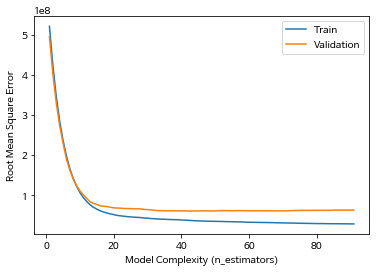

In [94]:
results = boosting.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

In [95]:
y_pred = boosting.predict(X_test_preprocessed)
print('RMSE 값 :', mean_squared_error(y_test, y_pred)**0.5)

RMSE 값 : 60646160.73509931


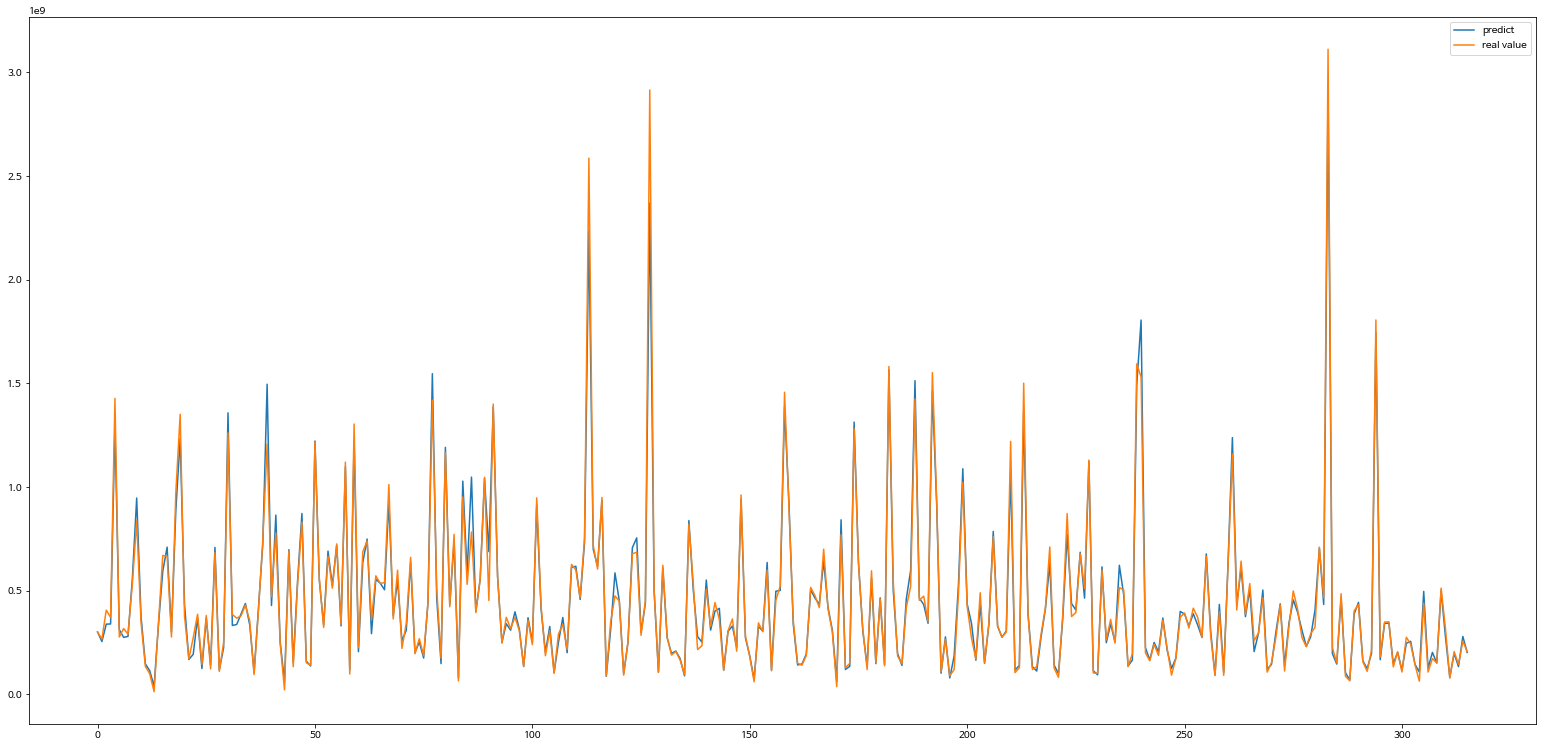

In [96]:
y_test.reset_index(drop=True, inplace=True)
plt.figure(figsize=(27,13))
plt.plot(y_test.index, y_pred,label = 'predict')
plt.plot(y_test.index, y_test,label = 'real value')
plt.legend();

## 순열중요도 확인

In [97]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    boosting, # model
    scoring='neg_root_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_preprocessed, y_test);

In [98]:
feature_names = X_test_preprocessed.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

총_토지경매면적   -1.743287e+06
주소_시       -5.741153e+05
주소_도        0.000000e+00
건물용도        0.000000e+00
지분경매여부      0.000000e+00
주소_동        1.303131e+05
현재층수        2.747029e+05
총층수         3.241594e+05
낙찰날짜        9.019731e+05
층수등급        2.591981e+06
낙찰시_건물나이    5.992988e+06
총_건물경매면적    1.135167e+07
유찰횟수        4.161519e+07
총_감정가       5.085358e+08
dtype: float64

In [99]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
508535796.1637 ± 13776533.5466,총_감정가
41615185.1651 ± 4116621.8071,유찰횟수
11351672.3926 ± 18182469.1742,총_건물경매면적
5992988.1278 ± 1469158.9241,낙찰시_건물나이
2591980.6121 ± 6194031.5898,층수등급
901973.1258 ± 1153628.9362,낙찰날짜
324159.4240 ± 872517.5896,총층수
274702.8620 ± 801404.3719,현재층수
130313.1186 ± 300360.4086,주소_동
0 ± 0.0000,지분경매여부


In [100]:
#중요도가 0이하인 특성 제거

minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train_preprocessed.columns[mask]
X_train_selected = X_train_preprocessed[features]
X_test_selected = X_test_preprocessed[features]

In [101]:
# XGBRegressor 생성
boosting = XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_selected, y_train), 
            (X_test_selected, y_test)]

boosting.fit(X_train_selected, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:5.20843e+08	validation_1-rmse:4.94403e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.24904e+08	validation_1-rmse:4.03719e+08
[2]	validation_0-rmse:3.48041e+08	validation_1-rmse:3.31668e+08
[3]	validation_0-rmse:2.86467e+08	validation_1-rmse:2.74879e+08
[4]	validation_0-rmse:2.37696e+08	validation_1-rmse:2.31078e+08
[5]	validation_0-rmse:1.98969e+08	validation_1-rmse:1.90949e+08
[6]	validation_0-rmse:1.67423e+08	validation_1-rmse:1.63621e+08
[7]	validation_0-rmse:1.42665e+08	validation_1-rmse:1.41279e+08
[8]	validation_0-rmse:1.22891e+08	validation_1-rmse:1.24428e+08
[9]	validation_0-rmse:1.06893e+08	validation_1-rmse:1.11064e+08
[10]	validation_0-rmse:9.4486e+07	validation_1-rmse:1.00715e+08
[11]	validation_0-rmse:8.45353e+07	validation_1-rmse:9.23865e+07
[12]	validation_0-rmse:7.63392e+07	validation_1-rmse:8.39829e+07
[13]	va

XGBRegressor(learning_rate=0.2, n_estimators=500, n_jobs=-1,
             objective='reg:squarederror')

In [131]:
y_pred = boosting.predict(X_test_selected)
print('RMSE 값 :', mean_squared_error(y_test, y_pred)**0.5)

RMSE 값 : 56810975.01953094


## PDP 해석

In [103]:
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

In [143]:
def draw_pdp(features):
  isolated = pdp_isolate(model=boosting, 
                         dataset=X_test_selected, 
                         model_features=X_test_selected.columns,
                         num_grid_points=30,
                         feature=features)
  plot_params = {
      'font_family': 'NanumBarunGothic'}
  pdp_plot(isolated, 
          feature_name=features,
          plot_lines=True, # plot_line을 그려줄건지?
          frac_to_plot=100, # ICE curves는 100개
          plot_pts_dist=True,
          plot_params=plot_params)
  

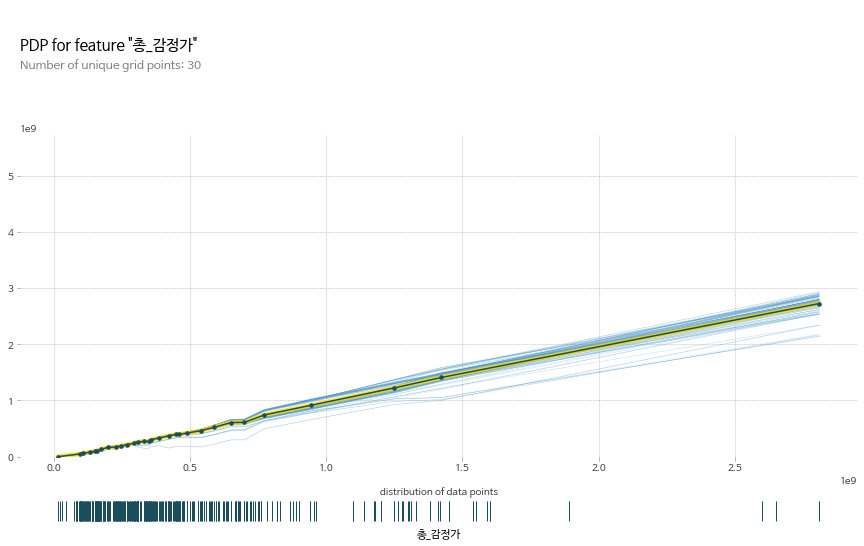

In [108]:
draw_pdp('총_감정가')

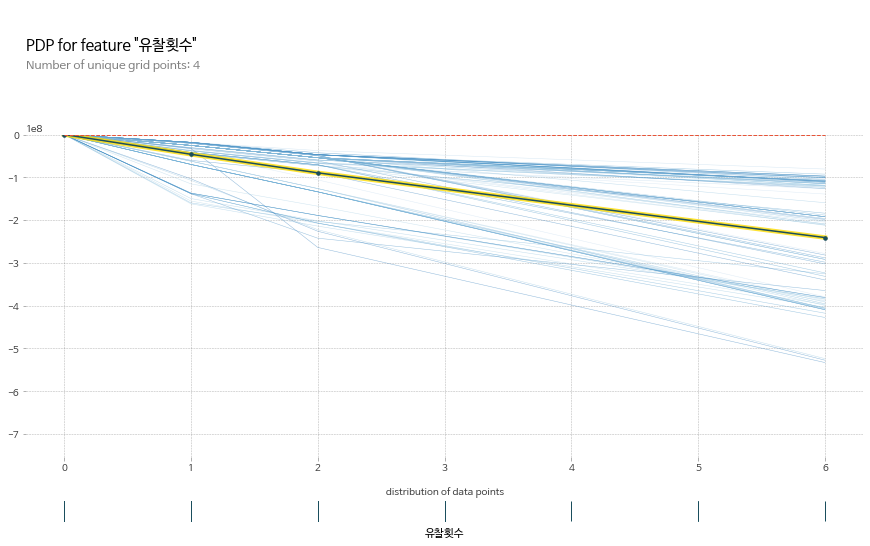

In [109]:
draw_pdp('유찰횟수')

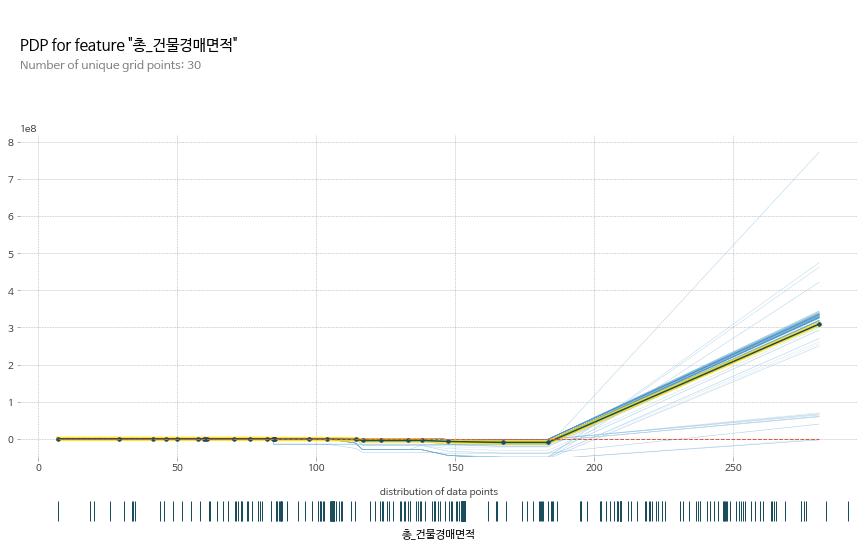

In [142]:
draw_pdp('총_건물경매면적')


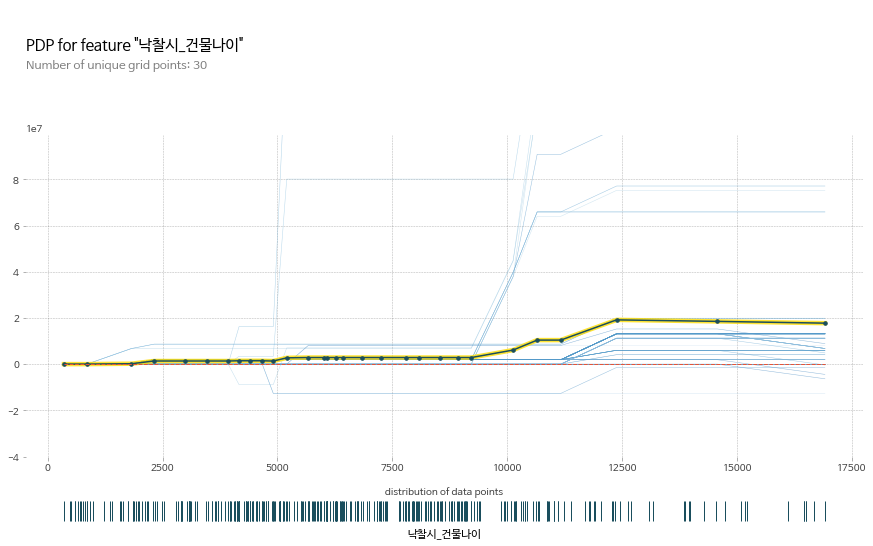

In [112]:
draw_pdp('낙찰시_건물나이')

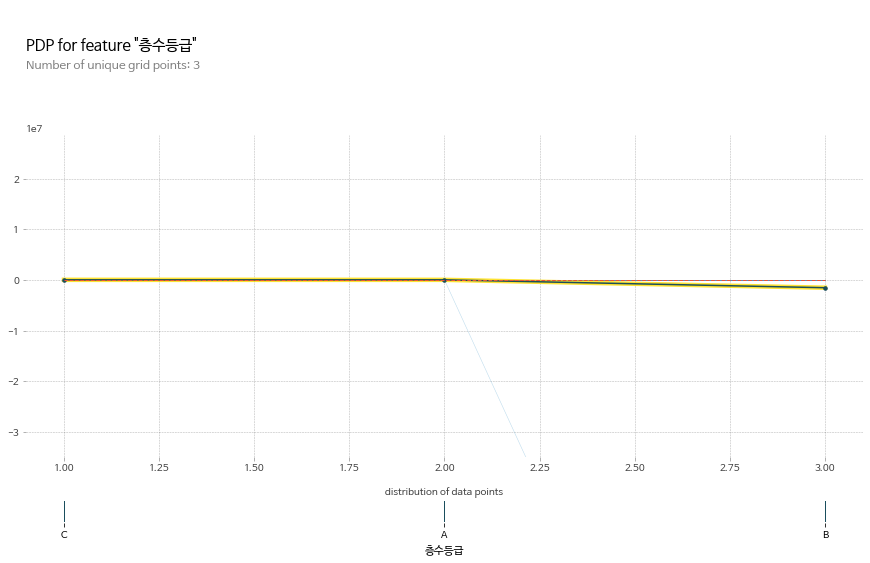

In [117]:
draw_pdp('층수등급')
plt.xticks([1, 2, 3], ['C', 'A', 'B']);

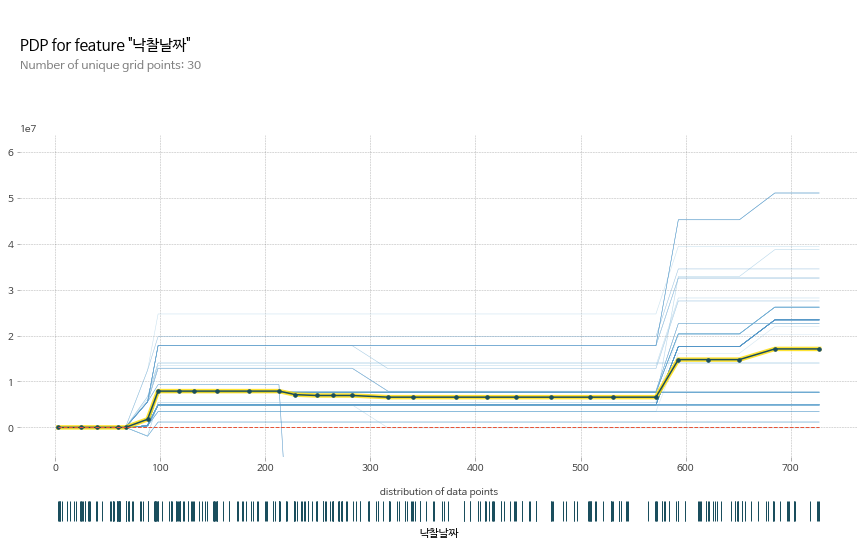

In [115]:
draw_pdp('낙찰날짜')

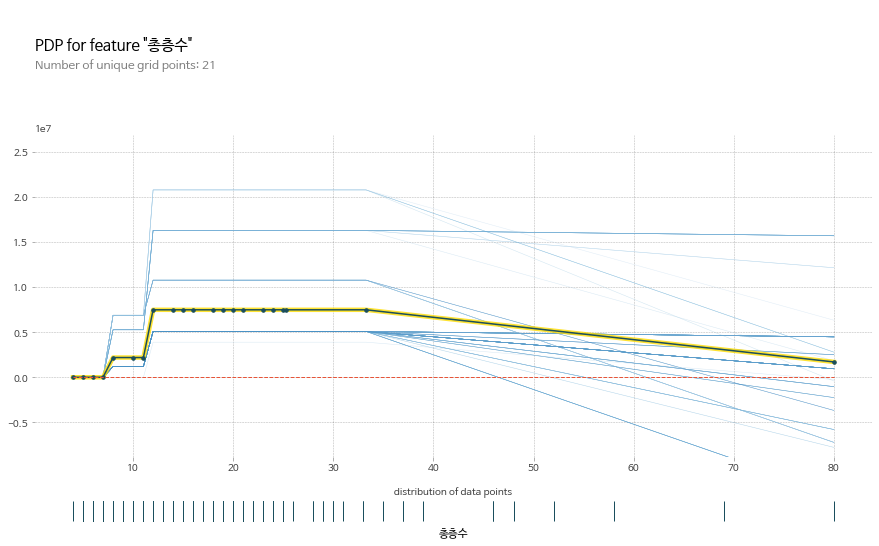

In [118]:
draw_pdp('총층수')

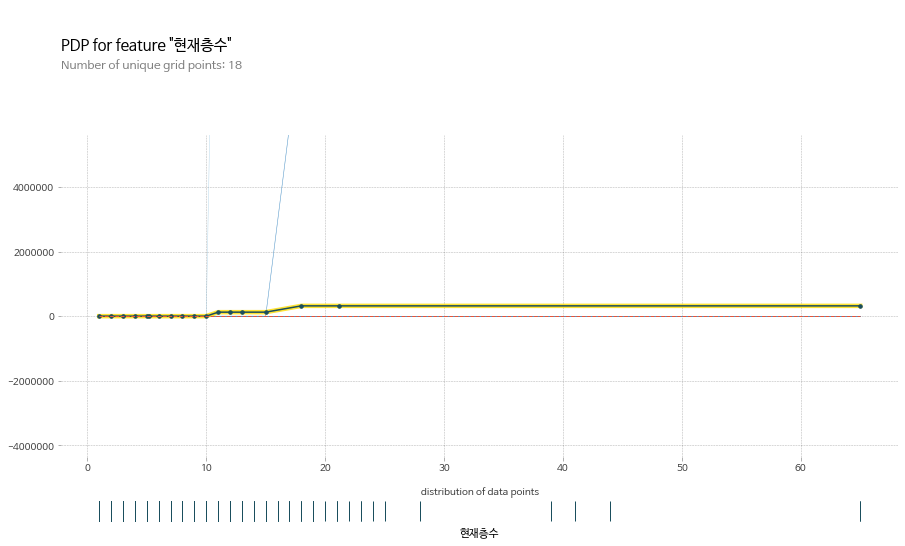

In [125]:
draw_pdp('현재층수')

## SHAP 분석

In [136]:
import shap

row = X_test_selected.iloc[[156]]
print('실제 가격 :', y_test.iloc[156])
explainer = shap.TreeExplainer(boosting)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

실제 가격 : 454400000


In [139]:
shap.initjs()
shap_values = explainer.shap_values(X_test_selected.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test_selected.iloc[:100])

## 감정가 특성을 제외할 시

In [36]:
df_select = df[['Auction_miscarriage_count', 'Total_land_auction_area', 'Total_building_auction_area', 'Final_auction_date', 'addr_do', 'addr_si', 'addr_dong', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor', 'Current_floor', 'Share_auction_YorN', 'Hammer_price']]
df_select.rename(columns = {'Auction_miscarriage_count':'유찰횟수',
                            'Total_land_auction_area':'총_토지경매면적',
                            'Total_building_auction_area':'총_건물경매면적',
                            'Final_auction_date':'낙찰날짜',
                            'addr_do':'주소_도',
                            'addr_si':'주소_시',
                            'addr_dong':'주소_동',
                            'Apartment_usage':'건물용도',
                            'Preserve_regist_date':'최초등기일',
                            'Total_floor':'총층수',
                            'Current_floor':'현재층수',
                            'Share_auction_YorN':'지분경매여부',
                            'Hammer_price':'낙찰가'},inplace=True)

# outlier 제거

df_select=df_select.drop(df_select[df_select['낙찰가'] > np.percentile(df_select['낙찰가'], 99.99)].index)

# 데이터 Split

target = '낙찰가'
features = df_select.columns.drop(target)

X_train, X_test, y_train, y_test = train_test_split(df_select[features], df_select[target], test_size=0.2)


def EDA(df):
  df_copy = df.copy()
# 최초 등기일 ~ 경매가 완료된 시기 까지의 기간 (건물 나이)
  df_copy['최초등기일'] = pd.to_datetime(df_copy['최초등기일'], errors = 'coerce')
  df_copy['낙찰날짜'] = pd.to_datetime(df_copy['낙찰날짜'], errors = 'coerce')
  df_copy['낙찰시_건물나이'] = (df_copy['낙찰날짜'] - df_copy['최초등기일']).dt.days
  df_copy.drop(columns='최초등기일', inplace=True)
# 경매가 완료된 시점->날짜 정보로 변환 (거래가 발생한 시기별 가격차이가 있는지?)
  cutoff = pd.to_datetime('2016-04-01')
  df_copy['낙찰날짜'] = (df_copy['낙찰날짜'] - cutoff).dt.days
# 아파트 층수에 대한 등급 부여
# 1. 아파트 총 층수가 10층 이하일때 -> 1,2,3층 : 1 / 4,5,6층 : 2 / 7,8,9,10 : 3
# 2. 아파트 총 층수가 10층 초과일때 -> 하위 30% : 1 / 상위40% : 3 / 나머지 : 2
  df_copy["층수등급"] = df_copy.apply(lambda x: '3' if ((x.총층수 <= 10) & (x.현재층수 >= 7)) or ((x.총층수 > 10) & ((x.현재층수 / x.총층수) >= 0.6))
                                            else '1' if ((x.총층수 <= 10) & (x.현재층수 <= 3)) or ((x.총층수 > 10) & ((x.현재층수 / x.총층수) <= 0.3)) 
                                            else '2', axis='columns')
  category_col = ['주소_도','주소_시','주소_동','건물용도','지분경매여부','층수등급']
  df_copy[category_col] = df_copy[category_col].astype('category')
  return df_copy

X_train_EDA = EDA(X_train)
X_test_EDA = EDA(X_test)

# preprocessing을 위한 pipeline 생성
pipe = make_pipeline(
                     OrdinalEncoder(),
                     SimpleImputer(strategy='median')
                    )
# X_train_EDA에 대한 preprocessing
X_train_preprocessed = pipe.fit_transform(X_train_EDA)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_EDA.columns)

# X_test_EDA에 대한 preprocessing
X_test_preprocessed = pipe.transform(X_test_EDA) # 검증데이터
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_EDA.columns)

# XGBRegressor 생성
boosting = XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_preprocessed, y_train), 
            (X_test_preprocessed, y_test)]

boosting.fit(X_train_preprocessed, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:5.31677e+08	validation_1-rmse:5.55031e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.54437e+08	validation_1-rmse:4.75047e+08
[2]	validation_0-rmse:3.94419e+08	validation_1-rmse:4.15942e+08
[3]	validation_0-rmse:3.47965e+08	validation_1-rmse:3.60303e+08
[4]	validation_0-rmse:3.10224e+08	validation_1-rmse:3.26445e+08
[5]	validation_0-rmse:2.82136e+08	validation_1-rmse:3.0269e+08
[6]	validation_0-rmse:2.59424e+08	validation_1-rmse:2.82968e+08
[7]	validation_0-rmse:2.42004e+08	validation_1-rmse:2.72159e+08
[8]	validation_0-rmse:2.25725e+08	validation_1-rmse:2.62198e+08
[9]	validation_0-rmse:2.13742e+08	validation_1-rmse:2.54438e+08
[10]	validation_0-rmse:2.04355e+08	validation_1-rmse:2.50979e+08
[11]	validation_0-rmse:1.95907e+08	validation_1-rmse:2.47761e+08
[12]	validation_0-rmse:1.9034e+08	validation_1-rmse:2.42665e+08
[13]	val

XGBRegressor(learning_rate=0.2, n_estimators=500, n_jobs=-1,
             objective='reg:squarederror')

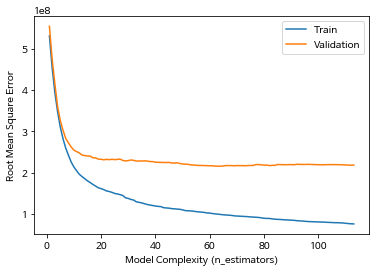

In [37]:
results = boosting.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

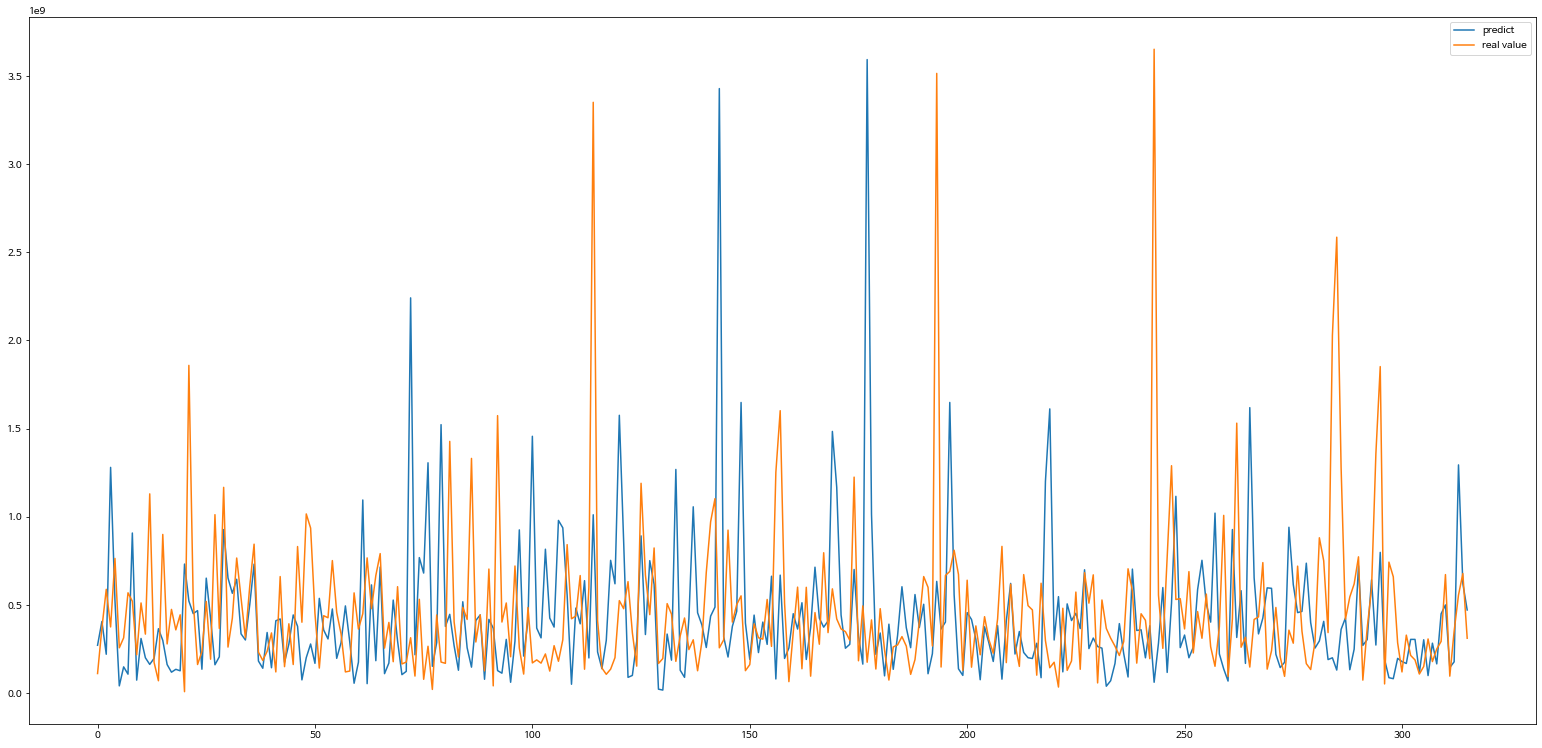

In [38]:
y_test.reset_index(drop=True, inplace=True)
plt.figure(figsize=(27,13))
plt.plot(y_test.index, y_pred,label = 'predict')
plt.plot(y_test.index, y_test,label = 'real value')
plt.legend();